# Indexation Web - TP1
BERNARD Renan

## Introduction

Tout d'abord les différentes importations nécessaires pour ce Notebook.
Les fonctions utilisées sont dans le fichier __utils.py__.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from functools import reduce
import multiprocessing

from utils import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mathilde/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Récupérons ensuite l'ensemble des données. Nous garderons un DataFrame contenons le texte, l'auteur et l'identifiant du document.

In [3]:
%%time
texts = generate_texts_dataframe()
texts.head()

CPU times: user 52 ms, sys: 16 ms, total: 68 ms
Wall time: 68 ms


,Text,Author,DocumentId
0,France's state-owned electricity utility Elect...,Marcel Michelson,18555
1,French carmakers Renault SA and Peugeot PSA sa...,Marcel Michelson,187829
2,The French government has started a wide consu...,Marcel Michelson,197891
3,The French Industry Minister on Wednesday angr...,Marcel Michelson,221246
4,French state-owned airline Air France said on ...,Marcel Michelson,141744


Lisons un article :

In [25]:
view_article(537, texts)


--------------------------------------------
Author : Jim Gilchrist
Id : 126597
--------------------------------------------
This is Reuters' 2nd ex-Hong Kong air cargo market report.
It will be published regulary until a new version is published at a later date.
HONG KONG, Oct 17 - (Reuter) Current average ex-Hong Kong air cargo market rates in Hong Kong dollars per kg for a 100kg shipment, with volume-to-weight of six to one.
						Oct 17	     Sept 30
				EUROPE
HK-LHR					22.25		20.85
HK-FRA					22.40		21.09
				USA
HK-JFK					20.70		20.50
HK-LAX					21.05		20.95
				MIDDLE EAST
HK-DXB					15.80	     15.18
				ASIA PACIFIC
HK-SIN					 9.10		9.06
HK-TAIPEI				    4.10		3.90
HK-TOKYO				    30.70	     30.50
* The rates in this report were obtained by Reuters journalists on a confidential basis from a range of airlines, large forwarders and smaller cargo agents.
* All prices were quoted in Hong Kong dollars.
* The tariffs represent average calculated from a range of prices and are ind

## Préparation des Textes - _Tokenization_

Le premier traitement est la transformation des phrases en une liste de mots contenant uniquement des caractères alphabétiques minuscules extraits à l'aide d'une expression régulière.

On enlève ensuite les 'stopWords' (_the_, _a_, _or_,...) qui n'apportent pas d'information sur le contenu de l'article.

Puis on a choisi d'utiliser un __stemmer__ pour transformer les mots en _tokens_. Cette méthode enlève les préfixes et suffixes des mots pour garder uniquement la racine. Celle-ci n'est pas forcement un mot qui existe réellement comme _ministri_, mais capte l'ensemble des mots "proches".

C'est la fonction __tokenize_text__ qui fait cette étape. Elle est présente dans __utils.py__.

La suite du traitement de texte se fera via ces listes de _tokens_.

## Indexation

### Création de l'Index

Afin de trouver rapidement les documents qui contiennent un certain _token_, nous créons un index. On a choisi de faire un index de la forme suivante :

{"token1" : {"total_occurences" : 4, 

             article1 : {"locations" : [12, 13, 14], 
             
                         "occurences" : 3}, 
                         
             article2 : {"locations" : [9], 
             
                         "occurences" : 1}}} 

La création de l'index pour un seul texte se fait via la fonction __create_index_from_text__. Celle-ci procède via une itération sur la liste de _tokens_ correspondant au texte pour ensuite enregistrer le nombre d'occurences des _tokens_ dans un index selon le modèle précédent.

La création de l'index final se fait alors en "additionant" les différents index via la foncion __sum_two_indexes__.
                               
Tout d'abord, regardons le temps d'exécution et le résultat via une itération sur l'ensemble des documents :

In [6]:
%%time
index = create_index_from_text(texts.Text[0], 0)
for i in range(1, len(texts)):
    index_i = create_index_from_text(texts.Text[i], i)
    index = sum_two_indexes(index, index_i)

CPU times: user 12.7 s, sys: 76 ms, total: 12.7 s
Wall time: 12.7 s


In [7]:
index['ministri']

{'total_occurences': 361,
 2: {'locations': [48, 69, 200], 'occurences': 3},
 3: {'locations': [95], 'occurences': 1},
 9: {'locations': [159], 'occurences': 1},
 11: {'locations': [222], 'occurences': 1},
 21: {'locations': [309], 'occurences': 1},
 24: {'locations': [167, 234], 'occurences': 2},
 26: {'locations': [113], 'occurences': 1},
 28: {'locations': [90], 'occurences': 1},
 41: {'locations': [97], 'occurences': 1},
 49: {'locations': [318], 'occurences': 1},
 50: {'locations': [20], 'occurences': 1},
 53: {'locations': [89], 'occurences': 1},
 56: {'locations': [28], 'occurences': 1},
 57: {'locations': [32], 'occurences': 1},
 62: {'locations': [31], 'occurences': 1},
 64: {'locations': [257], 'occurences': 1},
 70: {'locations': [43], 'occurences': 1},
 79: {'locations': [44], 'occurences': 1},
 94: {'locations': [34], 'occurences': 1},
 150: {'locations': [142], 'occurences': 1},
 155: {'locations': [170, 269], 'occurences': 2},
 158: {'locations': [98], 'occurences': 1},


Maintenant essayons avec l'architecture __MapReduce__, le _mapper_ correspondant à la création de l'index sur un seul text, le _reducer_ correspondant à la somme de deux index.

In [8]:
%%time 
def mapper(x):
    return create_index_from_text(texts.Text[x], x)

with multiprocessing.Pool(processes=4) as pool:
        results = pool.map(mapper, range(len(texts)))
        
index = reduce(sum_two_indexes, list(results))

CPU times: user 1.98 s, sys: 168 ms, total: 2.14 s
Wall time: 5.12 s


In [9]:
index['ministri']

{'total_occurences': 361,
 0: {'locations': [3, 64, 104, 146, 154, 197, 228, 315, 344, 352],
  'occurences': 10},
 2: {'locations': [91, 108], 'occurences': 2},
 3: {'locations': [228, 245], 'occurences': 2},
 7: {'locations': [142], 'occurences': 1},
 12: {'locations': [212], 'occurences': 1},
 13: {'locations': [2, 35, 60], 'occurences': 3},
 14: {'locations': [170, 269], 'occurences': 2},
 16: {'locations': [212, 295], 'occurences': 2},
 23: {'locations': [11, 55, 200, 203, 250], 'occurences': 5},
 25: {'locations': [233, 296, 311, 329], 'occurences': 4},
 26: {'locations': [142], 'occurences': 1},
 32: {'locations': [329], 'occurences': 1},
 33: {'locations': [115], 'occurences': 1},
 37: {'locations': [130, 228, 311], 'occurences': 3},
 41: {'locations': [30, 65, 77], 'occurences': 3},
 45: {'locations': [98], 'occurences': 1},
 46: {'locations': [226, 244], 'occurences': 2},
 47: {'locations': [130], 'occurences': 1},
 48: {'locations': [129], 'occurences': 1},
 82: {'locations':

Les résultats sont heureusement les mêmes, mais l'utilisation de __map__ et __reduce__ divise par quasiment 2 le temps de calcul (en fonction de la RAM de la machine, on peut augmenter le nombre de _processes_).

### Etude du Vocabulaire

In [9]:
%%time

def mapper(token):
    return {"Token" : token, "Occurences" : index[token]["total_occurences"]}

with multiprocessing.Pool(processes=4) as pool:
        results = pool.map(mapper, list(index.keys()))
        
df_vocabulary = pd.DataFrame(list(results)).sort_values("Occurences", ascending=False)

CPU times: user 68 ms, sys: 212 ms, total: 280 ms
Wall time: 422 ms


In [10]:
df_vocabulary.head()

,Occurences,Token
8,19856,said
63,7025,year
82,5658,compani
15,5296,percent
38,5202,would


Le _token_ le plus utilisé dans le corpus est __said__, puis __year__. Ces mots auraient pû être considérés comme des __stopWords__ (non-porteurs de sens) vu leur fréquence.

La loi de __Zipf__ est-elle vérifiée dans notre corpus ?

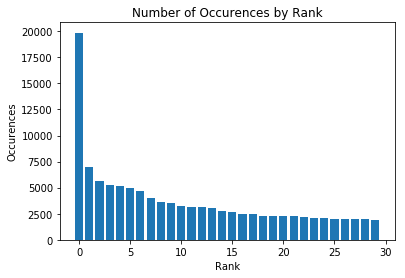

In [11]:
plt.bar(x=range(30), height=df_vocabulary.Occurences[:30])
plt.xlabel("Rank")
plt.ylabel("Occurences")
plt.title("Number of Occurences by Rank")
plt.show()

On peut voir la loi de __Zipf__ si on veut la voir. Le corpus étant d'une taille assez limitée (2500 textes), on peut supposer qu'il est normal d'avoir quelque chose de proche. Il est aussi important de rappeler que nous travaillons sur des _tokens_ et non des mots !

## _Ranking_ par occurences

Tout d'abord un schéma de requêtes simples : pour une phrase ou un mot, les documents sont ordonnées par leur nombre de _tokens_ total. Pour la requête __"china"__, les documents seront classés par leur nombre d'occurences du _token_ __china__. Pour la requête __"china and russia were communist"__, les documents seront classés par leur nombre d'occurences total des _tokens_ __china__, __russia__ et __communist__.

In [12]:
query = "china"
query_by_occurences(query, index, texts).head()

,china,Total,Text,Author,DocumentId
346,26,26.0,While China's leaders peppered 1996 with assur...,Lynne Donnell,275670
1760,24,24.0,"Now that China's Deng Xiaoping is dead, Hong K...",Sarah Davison,405565
1454,21,21.0,More foreign firms are finally beginning to re...,Graham Earnshaw,277010
918,20,20.0,China is unlikely to concede on its demand to ...,Jane Macartney,242519
915,20,20.0,China is unlikely to concede on its demand to ...,Jane Macartney,242319


In [34]:
query = "air cargo"
query_by_occurences(query, index, texts).head()

,air,cargo,Total,Text,Author,DocumentId
537,12,25,37.0,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
504,10,22,32.0,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
518,6,10,16.0,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504
539,5,10,15.0,Major airlines operating cargo flights to Euro...,Jim Gilchrist,156695
507,12,3,15.0,An American airline has successfully completed...,Jim Gilchrist,206567


Maintenant plus compliqué : repondons à une requête en respectant l'ordre des mots, les résutats seront classés de la même manière que les requêtes précédentes.

In [33]:
%%time
query = "air cargo"
query_by_ordered_occurences(query, index, texts).head()

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 39.4 ms


,Occurences,Text,Author,DocumentId
537,7,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
504,5,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
518,4,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504
541,3,The Hong Kong Shippers' Council is urging the ...,Jim Gilchrist,186190
505,3,Hong Kong civil aviation department statistics...,Jim Gilchrist,123517


In [35]:
%%time
query = "cargo air"
query_by_ordered_occurences(query, index, texts).head()

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 42 ms


,Occurences,Text,Author,DocumentId
539,1,Major airlines operating cargo flights to Euro...,Jim Gilchrist,156695


## _Ranking_ par Fréquences

Passons à un schéma de requêtes plus cohérent : en utilisant la fréquence des mots au sein d'un document.

In [29]:
%%time
query = "air cargo"
df = query_by_frequences(query, index, texts)
df.head()

CPU times: user 316 ms, sys: 0 ns, total: 316 ms
Wall time: 316 ms


,air,cargo,Total,Text,Author,DocumentId
505,0.0441176,0.0588235,0.102941,Hong Kong civil aviation department statistics...,Jim Gilchrist,123517
500,0.0384615,0.0512821,0.089744,Freight forwarders in Hong Kong say they have ...,Jim Gilchrist,11270
533,0.0212766,0.0638298,0.085106,Korean Air Lines Ltd's cargo load factor dropp...,Jim Gilchrist,21567
532,0.0294118,0.0441176,0.073529,Hong Kong civil aviation department statistics...,Jim Gilchrist,123524
530,0.0309278,0.0360825,0.067010,Air Macau said it expects to carry beween 20 a...,Jim Gilchrist,108091


## _Ranking_ par TF-IDF

## Métrique TF-IDF

t = term, D = corpus

$|d|$ : taille de l'article

$N_{t,d}=  \# \{t \epsilon d\}$ 

$f_{t,d} = \frac{N_{t,d}}{|d|}$

$|D|$ : taille du corpus

$N_t = \# \{d \epsilon D / t \epsilon  d \}$

$IDF_t = log(\frac{|D|}{1 + N_t})$

$TF-IDF_{t,d} = f_{t,d} * IDF_t$


In [51]:
%%time
query = "air cargo"
df = query_by_tfidf(query, index, texts)
df.head()

CPU times: user 376 ms, sys: 0 ns, total: 376 ms
Wall time: 374 ms


,air,cargo,Total,Text,Author,DocumentId
505,0.122237,0.201546,0.323783,Hong Kong civil aviation department statistics...,Jim Gilchrist,123517
500,0.106566,0.175707,0.282273,Freight forwarders in Hong Kong say they have ...,Jim Gilchrist,11270
533,0.0589514,0.218699,0.277650,Korean Air Lines Ltd's cargo load factor dropp...,Jim Gilchrist,21567
532,0.0814916,0.151159,0.232651,Hong Kong civil aviation department statistics...,Jim Gilchrist,123524
530,0.0856922,0.123629,0.209321,Air Macau said it expects to carry beween 20 a...,Jim Gilchrist,108091


## Représentation vectorielle avec TF-IFD

La matrice TF_IDF (la représation du corpus dans l'espace TF-IDF) est également créer suivant un modèle _MapReduce_, le __mapper__ étant le calcul du TF-IDF pour chaque documents d'un _token_, le __reducer__ étant une simple concaténation.

In [181]:
%%time
tf_idf_matrix = calculate_tf_idf_matrix(index, texts)

[nltk_data] Downloading package stopwords to /home/renan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 839 ms, sys: 267 ms, total: 1.11 s
Wall time: 1.12 s


### Mise en place d'une requête du corpus

Pour requêter (_query_) le corpus, nous calculons simplement le produit scalaire (_dot product_) de la représentation du texte de la requête dans l'espace TF-IDF par la matrice correspondant aux repréentations des documents. Le document dont le _dot product_ est le plus élevé, est le plus pertinent, etc.

In [192]:
%%time
df = query_corpus("air cargo", index, tf_idf_matrix, texts)
df.head()

CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 199 ms


,DotProduct,Text,Author,DocumentId
1330,0.586547,This is Reuters' 2nd ex-Hong Kong air cargo ma...,Jim Gilchrist,126597
1305,0.512567,Demand for space has eased slightly as a recen...,Jim Gilchrist,123461
1328,0.242321,Hong Kong Air Cargo Terminals Limited (HACTL) ...,Jim Gilchrist,133504
1306,0.235903,Major airlines operating cargo flights to Euro...,Jim Gilchrist,156695
1307,0.202684,Korean Air Lines Ltd's cargo load factor dropp...,Jim Gilchrist,21567


## ACP du Corpus

Tentons une ACP du corpus pour essayer d'identifier des tokens discriminants.

In [173]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components)
pca.fit(tf_idf_matrix)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [175]:
I = np.identity(tf_idf_matrix.shape[1])
coef = pca.transform(I)
columns = ['PC-' + str(i+1) for i in range(n_components)]
pca_results = pd.DataFrame(coef, columns=columns, index=range(tf_idf_matrix.shape[1]))
pca_results = pca_results.join(pd.DataFrame(index.keys(), columns=["Token"]))
pca_results = pca_results.sort_values("PC-10")
pca_results

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,Token
15457,-0.021355,-0.020387,-0.016048,-0.015191,-0.012396,-0.028967,-0.020222,-0.019274,-0.009138,-0.025574,sleigh
15448,-0.021355,-0.020387,-0.016048,-0.015191,-0.012396,-0.028967,-0.020222,-0.019274,-0.009138,-0.025574,whiff
15446,-0.021355,-0.020387,-0.016048,-0.015191,-0.012396,-0.028967,-0.020222,-0.019274,-0.009138,-0.025574,easter
15449,-0.021355,-0.020387,-0.016048,-0.015191,-0.012396,-0.028967,-0.020222,-0.019274,-0.009138,-0.025574,melancholi
15455,-0.021355,-0.020387,-0.016048,-0.015191,-0.012396,-0.028967,-0.020222,-0.019274,-0.009138,-0.025574,wax
...,...,...,...,...,...,...,...,...,...,...,...
15541,-0.021537,-0.019651,-0.015941,-0.016268,-0.010887,-0.027865,-0.016730,-0.012443,-0.010159,0.186655,ancestri
15542,-0.021537,-0.019651,-0.015941,-0.016268,-0.010887,-0.027865,-0.016730,-0.012443,-0.010159,0.186655,diaspora
15538,-0.021537,-0.019651,-0.015941,-0.016268,-0.010887,-0.027865,-0.016730,-0.012443,-0.010159,0.186655,newsstand
15536,-0.021537,-0.019651,-0.015941,-0.016268,-0.010887,-0.027865,-0.016730,-0.012443,-0.010159,0.186655,cosmopolitan


On peut observer que les coordonnées le long des axes sont très similaires d'un axe à l'autre. Globalement, on peut remarquer une distribution uniforme des coordonnées, l'ACP est donc un échec. On peut supposer qu'il n'est pas possible de discriminer avec un corpus aussi "petit".

## _Clustering_ du Corpus

In [169]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
kmeans = MiniBatchKMeans(n_clusters=2, random_state=10).fit(tf_idf_matrix)
#kmeans = KMeans(n_clusters=20, init='k-means++', n_init=30, n_jobs=-1).fit(tf_idf_matrix)

In [170]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_).T.join(pd.DataFrame(index.keys(), columns=["Token"])).sort_values(1, ascending=False)
cluster_centers

,0,1,Token
8112,0.007832,7.824446,geng
8114,0.007832,7.824446,methan
8108,0.007832,7.824446,klingner
8111,0.006425,5.705359,rong
8113,0.004489,2.242211,insofar
...,...,...,...
6263,0.000000,0.000000,bc
6264,0.000000,0.000000,ccl
6265,0.000000,0.000000,cogno
6266,0.000000,0.000000,cinram


In [171]:
cluster_documents = pd.DataFrame(kmeans.labels_, columns=['Cluster']).join(texts)

In [172]:
cluster_documents[cluster_documents.Cluster == 0]

,Cluster,Text,Author,DocumentId
0,0,"Russia's Fuel and Energy Ministry, sitting on ...",Lynnley Browning,116673
1,0,Russia's Western oil joint ventures are findin...,Lynnley Browning,248885
2,0,Russian oil company officials said on Friday t...,Lynnley Browning,314644
3,0,Azerbaijan is proving more successful in attra...,Lynnley Browning,219830
4,0,A multinational group trying to build a $1.5 b...,Lynnley Browning,239689
...,...,...,...,...
2495,0,Lucent Technologies Inc is beginning to reap t...,Nick Louth,140553
2496,0,MCI Communications Corp is ducking the trench ...,Nick Louth,133736
2497,0,MCI Communications Corp said on Sunday its $20...,Nick Louth,162173
2498,0,AT&amp;T Corp's proposed successor to Robert A...,Nick Louth,120591


Il ne semble pas possible d'obtenir des _clusters_ significatifs. On aura toujours un _cluster_ prenant l'ensemble des observations et le reste des _clusters_ ne contient qu'un document (ou son doublon).